In [15]:
import glob
import logging
import os
import random
import h5py

import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import webdataset
from omegaconf import open_dict, OmegaConf
from skimage.feature import canny
from skimage.transform import rescale, resize
from torch.utils.data import Dataset, IterableDataset, DataLoader, DistributedSampler, ConcatDataset

def normalize_depth(disparity_map):
    disparityf = disparity_map.astype(np.float32)
    disparity_not_zero = disparityf > 0.0
    disparity_zero = disparityf == 0.0
    true_depth = np.zeros(disparityf.shape)
    A = 1.0
    B = 0.0005
    max_depth = 1.0
    true_depth[disparity_not_zero] = 1/(A+B*disparityf[disparity_not_zero])
    true_depth[disparity_zero] = max_depth

    min_depth,max_depth = true_depth.min(), true_depth.max()
    true_depth_normalized = (true_depth - min_depth) / (max_depth - min_depth)
    return true_depth_normalized


def load_depth_from_hdf5(hdf5_path, depth_path, return_orig=False):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        # Access the dataset
        dataset = hdf5_file[depth_path]
        depth_map_u16 = dataset[:]
        
        # Retrieve mean and std attributes
        depth_map_min = dataset.attrs['min']
        depth_map_range = dataset.attrs['range']
        
        # Convert uint16 back to normalized float
        divisor = 65535.0 if depth_map_u16.dtype == np.uint16 else 255.0 
        depth_map_normalized = depth_map_u16.astype(np.float32) / divisor
        
        # Denormalize to reconstruct the original depth map
        depth = depth_map_normalized * depth_map_range + depth_map_min
        
        #out_depth = depth / np.max(depth)
        out_depth = normalize_depth(depth)

        if return_orig:
            return out_depth, depth
        else:
            return out_depth

In [49]:
class TestDepthInpaintingTrainWithHdf5Dataset:
    def __init__(self,indir, hdf5_path, mask_generator, transform):
        self.in_files = list(glob.glob(os.path.join(indir, '**', '*.jpg'), recursive=True))
        self.hdf5_path = hdf5_path
        
        # TODO note:
        # read self.in_files and create equivalent depth path inside the hdf5 file that we'll look up in load_depth_from_hdf5

        self.depth_files = [path.split(indir,1)[1].replace("\\","/").removesuffix(".jpg") for path in self.in_files]
        self.mask_generator = mask_generator
        self.transform = transform
        self.iter_i = 0

indir_train="D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/train"
hdf5_path_train="D:/dev/lama_stereoinpainting/docker/places/depth/train_large_places365standard_disparity_u8.hdf5"
thisTest_train = TestDepthInpaintingTrainWithHdf5Dataset(indir_train, hdf5_path_train, None, None)

1803460
D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/train\data_large\f\fastfood_restaurant\00000939.jpg


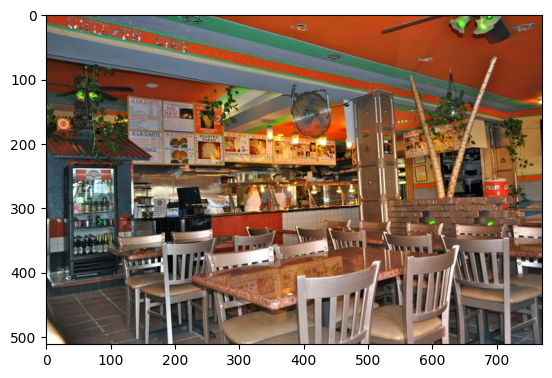

loading depth /data_large/f/fastfood_restaurant/00000939


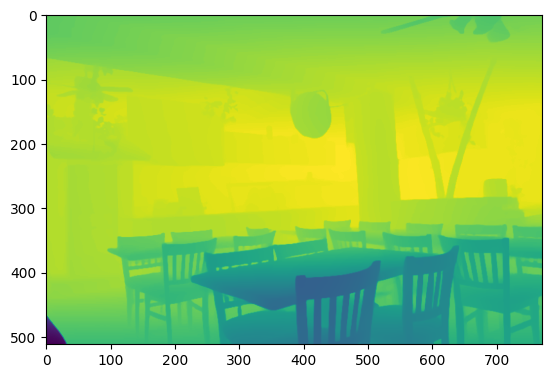

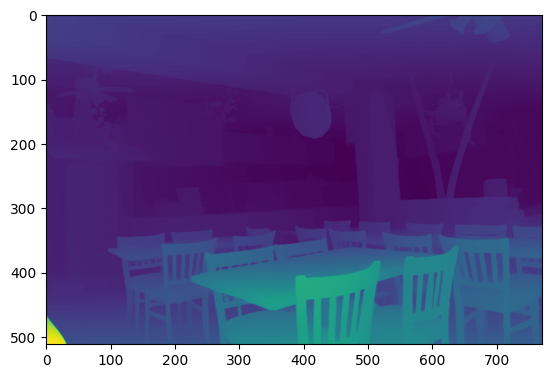

0.0 1.0
3.2199905 854.7271


In [96]:
import matplotlib.pyplot as plt

def test_rand_image(dataset):
    selected = np.random.randint(0, len(dataset.in_files))

    print(len(dataset.in_files))
    print(dataset.in_files[selected])

    tst_img = cv2.cvtColor(cv2.imread(dataset.in_files[selected]),cv2.COLOR_BGR2RGB)
    plt.imshow(tst_img)
    plt.show()

    depth_path = dataset.depth_files[selected]
    print(f"loading depth {depth_path}")

    depth_img, orig_depth = load_depth_from_hdf5(dataset.hdf5_path, depth_path, True)
    plt.imshow(depth_img)
    plt.show()
    plt.imshow(orig_depth)
    plt.show()
    print(depth_img.min(), depth_img.max())
    print(orig_depth.min(), orig_depth.max())

test_rand_image(thisTest_train)


1989
D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/val\Places365_test_00073356_crop000.png


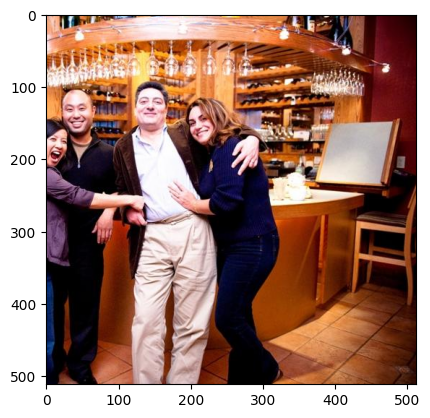

loading depth val/Places365_test_00073356_crop000


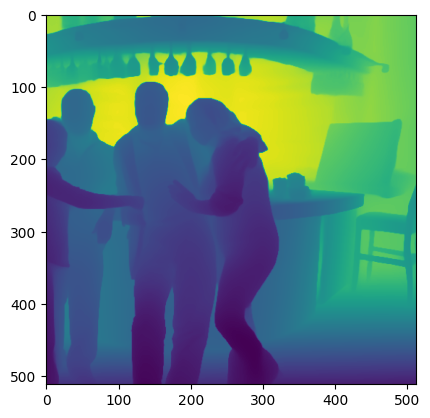

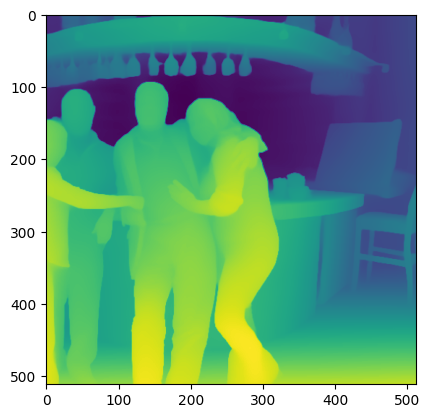

0.0 1.0
4.384225 328.06113


In [ ]:
class TestDepthInpaintingEvaluationWithHdf5Dataset:
    def __init__(self, img_datadir, hdf5_path, img_suffix='.jpg', pad_out_to_modulo=None, scale_factor=None):
        self.img_datadir = img_datadir
        self.hdf5_path = hdf5_path
        self.mask_filenames = sorted(list(glob.glob(os.path.join(self.img_datadir, '**', '*mask*.*'), recursive=True)))
        self.img_filenames = [fname.rsplit('_mask', 1)[0] + img_suffix for fname in self.mask_filenames]
        self.depth_paths = [path.replace(img_datadir, "val").replace("\\","/").removesuffix(img_suffix) for path in self.img_filenames]
        self.pad_out_to_modulo = pad_out_to_modulo
        self.scale_factor = scale_factor

indir_val = "D:/dev/lama_stereoinpainting/docker/places/places_standard_dataset/val"
hdf5_path_val="D:/dev/lama_stereoinpainting/docker/places/depth/val_large_places365standard_disparity_u8.hdf5"
thisTest_val = TestDepthInpaintingEvaluationWithHdf5Dataset(indir_val, hdf5_path_val, ".png", None, None)

thisTest_val.in_files = thisTest_val.img_filenames
thisTest_val.depth_files = thisTest_val.depth_paths

test_rand_image(thisTest_val)